In [1]:
import os, sys; sys.path.append("/home/choij/workspace/ChargedHiggsAnalysis/libPython")
import numpy as np
import pandas as pd
import torch
from torch_geometric.loader import DataLoader
from sklearn.utils import shuffle
from ROOT import TFile, TTree, TH1D
from Preprocess import rtfileToDataList, GraphDataset
from Models import ParticleNet, ParticleNetLite

WORKDIR = "/home/choij/workspace/ChargedHiggsAnalysis"
CHANNEL = "Skim3Mu"
SIG = "MHc-70_MA-65"
BKG = "TTLL_powheg"

Welcome to JupyROOT 6.26/08


In [2]:
def readFitness(SIG, BKG):
    BASEDIR = f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}"
    fitnessDict = {}
    for i in range(5):
        csv = pd.read_csv(f"{BASEDIR}/CSV/GAOptimGen{i}.csv").transpose()
        thisFitness = []
        for idx in csv.index: thisFitness.append(float(csv.loc[idx, 'fitness']))
        fitnessDict[f"Gen{i}"] = thisFitness

    return fitnessDict


### Get chromosomes(i.e. hyperparameters) with best fintess generation
def getChromosomes(SIG, BKG):
    # get mean fitness values
    fitness = readFitness(SIG, BKG)
    meanFitness = {}
    for key, value in fitness.items(): meanFitness[key] = np.mean(value)

    # choose lowest mean fitness generation
    minFitness = sorted(meanFitness.items(), key=lambda item: item[1])[0]
    gen = minFitness[0]

    # read csv file
    BASEDIR = f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}"
    csv = pd.read_csv(f"{BASEDIR}/CSV/GAOptim{gen}.csv").transpose()

    return gen, csv

In [3]:
##### load datasets
rtSig = TFile.Open(f"{WORKDIR}/data/Combined/{CHANNEL}__/{SIG}.root")
rtBkg = TFile.Open(f"{WORKDIR}/data/Combined/{CHANNEL}__/{BKG}.root")
sigDataList = shuffle(rtfileToDataList(rtSig, isSignal=True), random_state=42); rtSig.Close()
bkgDataList = shuffle(rtfileToDataList(rtBkg, isSignal=False), random_state=42); rtBkg.Close()
dataList = shuffle(sigDataList+bkgDataList, random_state=42)

trainset = GraphDataset(dataList[:int(len(dataList)*0.6)])
validset = GraphDataset(dataList[int(len(dataList)*0.6):int(len(dataList)*0.7)])
testset  = GraphDataset(dataList[int(len(dataList)*0.7):])

trainLoader = DataLoader(trainset, batch_size=1024, shuffle=False, pin_memory=True)
validLoader = DataLoader(validset, batch_size=1024, shuffle=False, pin_memory=True)
testLoader  = DataLoader(testset, batch_size=1024, shuffle=False, pin_memory=True)

@@@@ no. of dataList ends with 105000
@@@@ no. of dataList ends with 105000


In [4]:
##### load models
gen, csv = getChromosomes(SIG, BKG)
models = {}
for idx in csv.index:
    modelName, optimizer, initLR, scheduler = eval(csv.loc[idx, 'chromosome'])
    modelPath = f"{WORKDIR}/GraphNeuralNet/{CHANNEL}/{SIG}_vs_{BKG}/models/{modelName}_{optimizer}_initLR-{str(initLR).replace('.', 'p')}_{scheduler}.pt"
    if modelName == "ParticleNet": model = ParticleNet(9, 2)
    else:                          model = ParticleNetLite(9, 2)
    model.load_state_dict(torch.load(modelPath, map_location=torch.device('cpu')))

    models[idx] = model

In [34]:
model = models['0']
model.eval()

hSigTrainDict = {}
hSigTestDict = {}
hBkgTrainDict = {}
hBkgTestDict = {}
hSigTrain = TH1D("hSigTrain", "", 1000, 0., 1.)
hSigTest = TH1D("hSigTest", "", 1000, 0., 1.)

for i in range(len(trainLoader)): 
    hSigTrainDict[i] = TH1D(f"hSigTrain_{i}", "", 1000, 0., 1.)
    hBkgTrainDict[i] = TH1D(f"hBkgTrain_{i}", "", 1000, 0., 1.)
for i in range(len(testLoader)): 
    hSigTestDict[i] = TH1D(f"hSigTest_{i}", "", 1000, 0., 1.)
    hBkgTestDict[i] = TH1D(f"hBkgTest_{i}", "", 1000, 0., 1.)

for i, data in enumerate(trainLoader):
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.batch)
        for j, score in enumerate(out):
            if data.y[j]: 
                hSigTrainDict[i].Fill(score[1])
                hSigTrain.Fill(score[1])
            else:         hBkgTrainDict[i].Fill(score[1])
            
for i, data in enumerate(testLoader):
    with torch.no_grad():
        out = model(data.x, data.edge_index, data.batch)
        for j, score in enumerate(out):
            if data.y[j]: 
                hSigTestDict[i].Fill(score[1])
                hSigTest.Fill(score[1])
            else:         hBkgTestDict[i].Fill(score[1])

In [35]:
hSigTrain.KolmogorovTest(hSigTest, option="X")

0.768

In [31]:
import random

h_ksprob = TH1D("hKS", "", 100, 0., 1.)

for _ in range(10000):
    hSigTrain = random.choice(list(hSigTrainDict.values()))
    hSigTest = random.choice(list(hSigTestDict.values())) 
    ksprob = hSigTrain.KolmogorovTest(hSigTest)
    h_ksprob.Fill(ksprob)

Warning in <TROOT::Append>: Replacing existing TH1: hKS (Potential memory leak).


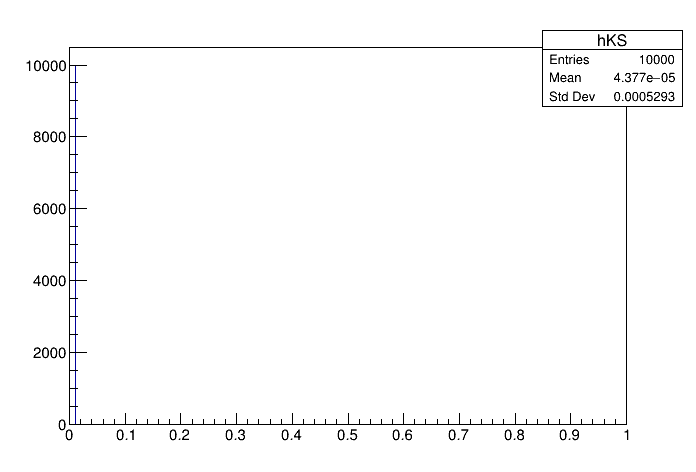

In [32]:
from ROOT import TCanvas

can = TCanvas()
can.cd()
h_ksprob.Draw()
can.Draw()